# A demo of the spectral method for structured models

In this demo, we are going to apply the Wigner rank one denoising problem to a structured model. To do so, we are simply downloading the MNIST data set, and use a very simple (some would say trivial) model for its structure by simply measuring the covariance matrix $\Sigma$ between images. As we shall see, this is enough to improve on the spectral method.

First, we download the MNIST dataset:

60000 train set
10000 test set


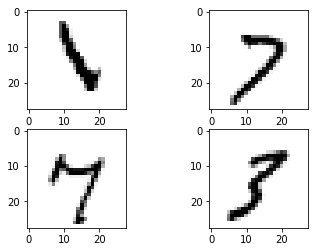

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the fashion-mnist pre-shuffled train data and test data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Print the number of training and test datasets
print(x_train.shape[0], 'train set')
print(x_test.shape[0], 'test set')

plt.subplot(221)
img_index = 51432
plt.imshow(x_train[img_index],cmap='Greys')

plt.subplot(222)
img_index = 567
plt.imshow(x_train[img_index],cmap='Greys')

plt.subplot(223)
img_index = 26579
plt.imshow(x_train[img_index],cmap='Greys')

plt.subplot(224)
img_index = 8765
plt.imshow(x_train[img_index],cmap='Greys')

All right, let us build our data set for the rank-one problem. We center the data, normalize them, and compute the empirical correlation $\Sigma$.

In [2]:
data=x_train.reshape(60000,784)-np.sum(x_train.reshape(60000,784),1).reshape(60000,1)/784
data=tf.keras.utils.normalize(data, axis=-1,order=2)*np.sqrt(784)
SIGMA=data.T@data/60000;

data_test=x_test.reshape(10000,784)-np.sum(x_test.reshape(10000,784),1).reshape(10000,1)/784
data_test=tf.keras.utils.normalize(data_test, axis=-1,order=2)*np.sqrt(784)

All right, now, let us pick up a given unseen image from the test set and do the rank one stuff:

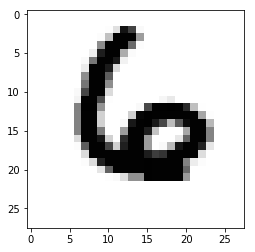

In [3]:
#x=data_test[2209].reshape(784,1)
x=data_test[5609].reshape(784,1)
plt.imshow(x.reshape(28,28),cmap='Greys')

In [4]:
N = 784
#create noise, and the random matrix observation:
b = np.random.randn(N,N)
W = np.tril(b) + np.tril(b, -1).T
DELTA=3
Y = x@x.T/(N) + np.sqrt(DELTA)*W/np.sqrt(N)

First, we try to apply the standard PCA approach:

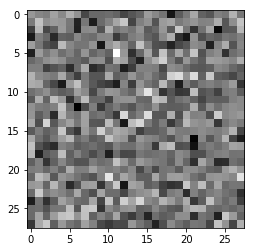

In [5]:
from scipy.sparse.linalg import eigsh,eigs
# Method one: naive PCA
val, vec = eigsh(Y, k=1,which='LA')
plt.imshow(vec.reshape(28,28),cmap='Greys')

And the improve spectral approach, that uses the correlation:

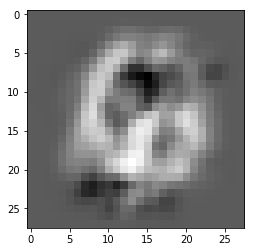

In [6]:
# Method two: linearized AMP: LAMP
val, vec = eigs(SIGMA@(Y-np.eye(784,784)), k=1,which='LR')
plt.imshow((vec.real).reshape(28,28),cmap='Greys')

The difference is really strinking. We can actually plot the mean-square error that the two methods yields as a function of $\Delta$:

In [7]:
MSEs = np.zeros((50,2))
deltas = np.zeros((50,1))
DELTA=0
d_DELTA=1

for i in range(50):
    #create noise
    b = np.random.randn(N,N)
    W = np.tril(b) + np.tril(b, -1).T
    DELTA=DELTA+d_DELTA
    Y = x@x.T/(N) + np.sqrt(DELTA)*W/np.sqrt(N)
    
    deltas[i]=DELTA
    # PCA
    val, vec = eigsh(Y, k=1,which='LA')
    error_1=sum((x/np.sqrt(N) - vec)**2)
    error_2=sum((x/np.sqrt(N) + vec)**2)
    MSEs[i,0]=min(error_1,error_2)
    
     # LAMP
    val, vec = eigs(SIGMA@(Y-np.eye(784,784)), k=1,which='LR')
    error_1=sum((x/np.sqrt(N) - vec.real)**2)
    error_2=sum((x/np.sqrt(N) + vec.real)**2)
    MSEs[i,1]=min(error_1,error_2)

    print(DELTA," ",MSEs[i,0]," ",MSEs[i,1])

1   1.4872407459936048   0.16738399009186705
2   1.9402286476760946   0.27718094291991835
3   1.9490870239842817   0.2967250271008078
4   1.897655260557435   0.2798257132253814
5   1.723554770444399   0.3925387373825087
6   1.9317558703527342   0.33362861827090223
7   1.9921236723346303   0.543852508035826
8   1.7060738989777624   0.4130391402179883
9   1.9494762839795565   0.500179213677947
10   1.8003176146023554   0.5250980326106209
11   1.9952471952771829   0.4465798831202047
12   1.7645761394647226   0.42741766338912807
13   1.920196533151087   0.5470121891677585
14   1.9951895065505056   0.453954213719709
15   1.8854261055233545   0.421289832398373
16   1.8737287588234584   0.3908781947556162
17   1.969029280760767   0.4980357206563001
18   1.9750789274549714   1.4377376989335573
19   1.9934410722226485   0.6716285593719419
20   1.871197910432821   0.6641459600694601
21   1.9687515667886883   0.9714898351901695
22   1.9546849649145097   0.815710175685861
23   1.9077499014736157  

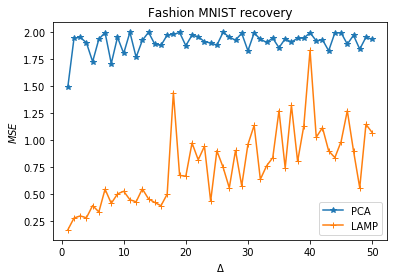

In [8]:
plt.figure()
plt.title("Fashion MNIST recovery")
plt.plot(deltas,MSEs[:,0],'*-', label='PCA')
plt.plot(deltas,MSEs[:,1],'+-', label='LAMP')
plt.xlabel("$\Delta$")
plt.ylabel("$MSE$")
plt.legend()